In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
import bnn.functions
import bnn.network
import bnn.layer
import bnn.loss

In [4]:
#dims = [32]*3 + [128]*3 + [1024]*10 + [128]*3 + [32]*10
dims = [d*2 for d in [8, 16, 32, 64, 64, 64, 32, 16, 8]]
TBNN = bnn.network.TernBinNetwork(*dims)

TypeError: TernBinNetwork.__init__() takes from 2 to 4 positional arguments but 10 were given

In [ ]:
W_zero_prob = [0.3 + n for n in np.random.randn(len(TBNN.layers)) * 0.1]
W_mean = [
    (0.1 + n) * sign 
    for n, sign in 
    zip(
        np.random.randn(len(TBNN.layers)) * 0.1,
        np.sign(np.random.randn(len(TBNN.layers))),
    )
]

for zp, m in zip(W_zero_prob, W_mean):
    print(zp, m)

0.3867657028527481 -0.02008137060712316
0.15285626512629782 -0.2565954049370498
0.39047446188142676 -0.034282618353045774
0.2699974157030588 0.04579624872181293
0.3329708972999409 0.19830101594317484
0.20378080481378727 -0.1183583135308522
0.4938545902047684 0.01404753257772351
0.2785499306421146 -0.04195745995818141


In [ ]:
TBNN._initialise(W_mean=W_mean, W_zero_prob=W_zero_prob)

In [5]:
checked_one = False

# assert integers
for p in TBNN.parameters():
    checked_one = True
    all_ints = True
    if torch.is_floating_point(p) or torch.is_complex(p):
        print(p.dtype)
        all_ints = False

assert all_ints
assert checked_one

NameError: name 'TBNN' is not defined

In [229]:
samples = 1000

input = bnn.functions.binarise(torch.randn(samples, dims[0])).to(torch.int)
desired = bnn.functions.binarise(torch.randn(samples, dims[-1])).to(torch.int)

In [230]:
output = TBNN.forward(input)
output.shape

torch.Size([1000, 16])

In [231]:
loss_func: bnn.loss.LossFunction = bnn.loss.l1

In [232]:
loss = loss_func.forward(output=output, target=desired)
loss

tensor(15712)

In [233]:
grad = loss_func.backward(output=output, target=desired)
grad.shape

torch.Size([1000, 16])

In [234]:
out_grad = TBNN.backward(grad)
out_grad.shape

torch.Size([1000, 16])

In [235]:
# check grads and Ws match
for layer in TBNN.layers.values():
    layer: bnn.layer.TernBinLayer
    assert layer.W.shape == layer.W.grad.shape

In [236]:
list(TBNN.layers.values())[len(dims)//2].W.grad

tensor([[ -94,  -41,  -39,  ...,  -10,    2,  -90],
        [ -32,  -41,   37,  ...,   24,   42,   -6],
        [ -68,   15,   -1,  ...,  -42, -106,    4],
        ...,
        [ -18,   47,  -29,  ...,  -76,   32,   32],
        [  34,  -71,  -35,  ...,   36,  -78,  -60],
        [  86,    1,   11,  ...,  -38,   46,   62]], dtype=torch.int32)

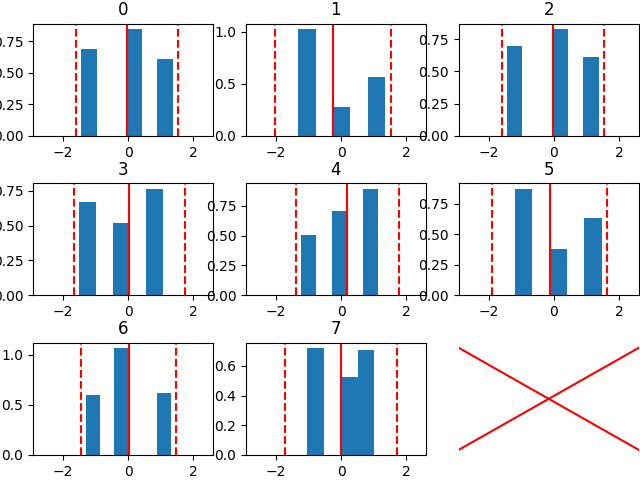

In [237]:
FIG_NAME = "W distribution"
plt.close(FIG_NAME)

data = [layer.W for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

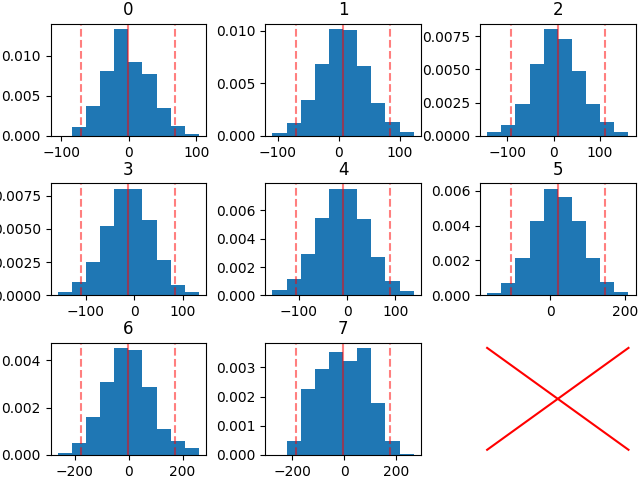

In [238]:
FIG_NAME = "W_grad distribution"
plt.close(FIG_NAME)

data = [layer.W.grad for layer in TBNN.layers.values()]
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-", alpha=0.5)
        ax.axvline(mean+2*std, color="red", ls="--", alpha=0.5)
        ax.axvline(mean-2*std, color="red", ls="--", alpha=0.5)


for ax in axs:
    #ax.set_xlim(min_x, max_x)
    pass
        

fig.tight_layout(pad=0.1)

plt.show()

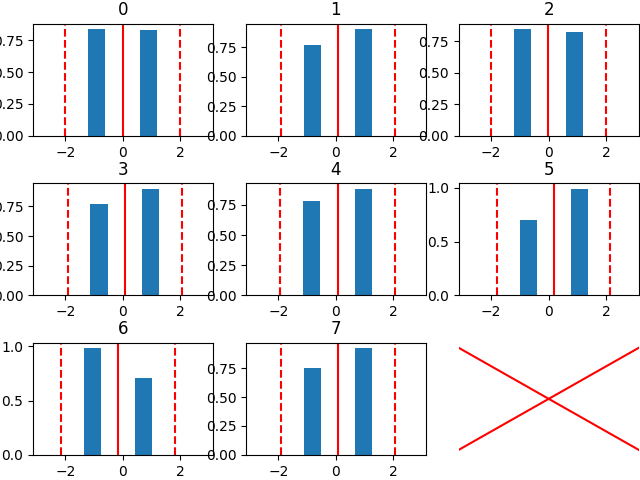

In [239]:
FIG_NAME = "activation distribution"
plt.close(FIG_NAME)

data = TBNN.input.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()

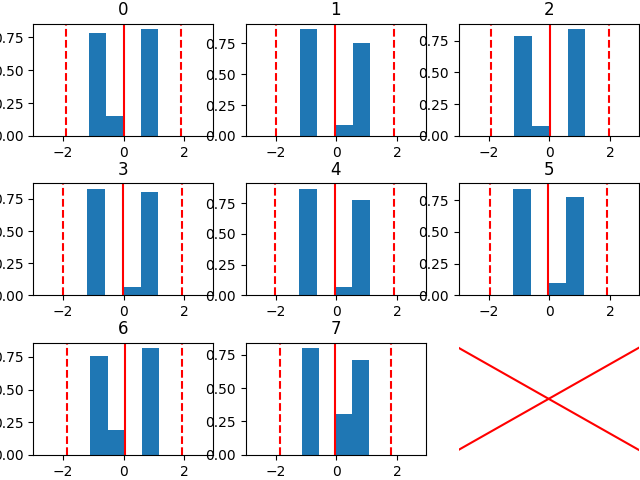

In [240]:
FIG_NAME = "grad distribution"
plt.close(FIG_NAME)

data = TBNN.grad.values()
data = list(data)

ceil_sqrt_num_ys = np.ceil(np.sqrt(len(data))).astype(int)
fig, axs = plt.subplots(ceil_sqrt_num_ys, ceil_sqrt_num_ys, num=FIG_NAME)
axs = np.array(axs).flatten()

min_x, max_x = -1, 1

for i, (ax, datum) in enumerate(zip(axs, data + [None]*len(axs))):
    if datum is None:
        ax.plot(np.linspace(min_x, max_x), np.linspace(-1, 1), '-', color="red")
        ax.plot(np.linspace(max_x, min_x), np.linspace(-1, 1), '-', color="red")
        ax.axis("off")
    else:
        ax.set_title(i)

        datum_float = datum.to(torch.float)
        mean = datum_float.mean().item()
        std = datum_float.std().item()

        datum_flat = datum.flatten()
        samples = 10000
        skip = int(np.ceil(len(datum_flat)/samples))
        ax.hist(datum_flat[::skip], range=(mean-3*std, mean+3*std), density=True)
        #ax.hist(Y.flatten(), density=True, color="cyan")

        min_x = min(min_x, mean-3*std)
        max_x = max(max_x, mean+3*std)

        ax.axvline(mean, color="red", ls="-")
        ax.axvline(mean+2*std, color="red", ls="--")
        ax.axvline(mean-2*std, color="red", ls="--")


for ax in axs:
    ax.set_xlim(min_x, max_x)
        

fig.tight_layout(pad=0.1)

plt.show()